In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import sys
import pandas as pd

sys.path.insert(0, '../src/data')
sys.path.insert(0, '../src/features')
sys.path.insert(0, '../src/models')
sys.path.insert(0, '../src/visualization')

from data_manager import DataManager
from pretreatment import load_raw_data, save_raw_data, create_superclasses
from constants import Constants

from ada_boost import AdaBoost
from decision_tree import DecisionTree
from k_means import KMeans
from svm import Svm
from neural_network import NeuralNetwork
from perceptron import Perceptron

from visualize import Visualize

## Prétraitement des données

In [16]:
raw_path = '../data/raw/train.csv'
superclasses_path = '../data/processed/superclasses.csv'

### Superclasses

In [4]:
# create_superclasses(raw_path, superclasses_path)

## Chargement des données

In [17]:
path = raw_path
# path = superclasses_path

In [18]:
dataManager = DataManager(path=path)

constants, x_train, x_test, t_train, t_test = dataManager.load_data()
# constants.print()
t_train_onehot = dataManager.one_hot_encoding(t_train)
t_test_onehot = dataManager.one_hot_encoding(t_test)

print(f"x_train.shape: {x_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"t_train.shape: {t_train.shape}")
print(f"t_test.shape: {t_test.shape}")


x_train.shape: (792, 192)
x_test.shape: (198, 192)
t_train.shape: (792,)
t_test.shape: (198,)


## Préparation du modèle

### Perceptron

In [19]:
model = Perceptron(constants)
hyperparameters_choices = {
	"alpha": [0.1, 0.2, 0.01],
	"max_iter": [100, 200, 300],
}

### Réseau de neurones

In [ ]:
model = NeuralNetwork(constants)
# hyperparameters_choices = {
# 	"alpha": [1e-5],
# 	"max_iter": [300],
# 	"batch_size": [32, "auto"],
# 	"hidden_layer_sizes" : [(100,1), (75, 2), (50, 3)]
# }
hyperparameters_choices = {
	"alpha": [1e-4],
	"max_iter": [500],
	"batch_size": ["auto"],
	"hidden_layer_sizes" : [(100,)]
}

### Adaboost

In [58]:
model = AdaBoost(constants)
hyperparameters_choices = {
	"n_estimators": [262, 275, 287],
	"learning_rate": [0.12, 0.025, 0.037]
}

### SVM

In [ ]:
model = Svm(constants)
hyperparameters_choices = {		# SVM doesn't have hyperparameters in the traditional sense, but we can optimize C (regularization parameter)
	"C": [1, 10, 100, 1000]
}

### Arbre de décision

In [ ]:
model = DecisionTree(constants)
hyperparameters_choices = {
	# TODO: add hyperparameters
}

### K-means

In [ ]:
model = KMeans(constants)
hyperparameters_choices = {		# KMeans doesn't have hyperparameters like SVM, but we can optimize the number of clusters (k)
	'n_clusters': [2, 3, 4, 5],
	'n_init': ["auto", 10]
}

## Apprentissage du modèle

In [59]:
hyperparameters = model.find_optimal_hyperparameters(x_train, t_train, hyperparameters_choices)
print(f"hyperparameters: {hyperparameters}")

hyperparameters: {'learning_rate': 0.037, 'n_estimators': 287}


In [22]:
model.train(x_train, t_train, hyperparameters)

## Tests et visualisation

In [23]:
t_pred = model.predict(x_test)
t_pred_proba = model.model.predict_proba(x_test)

In [24]:
visualize = Visualize(constants, t_test, t_pred, t_pred_proba)

In [25]:
# visualize.print_labels_scores()
visualize.print_mean_scores()

Log Loss       = 2.679
Accuracy       = 0.626
Mean precision = 0.651
Mean recall    = 0.626
Mean F1 score  = 0.596


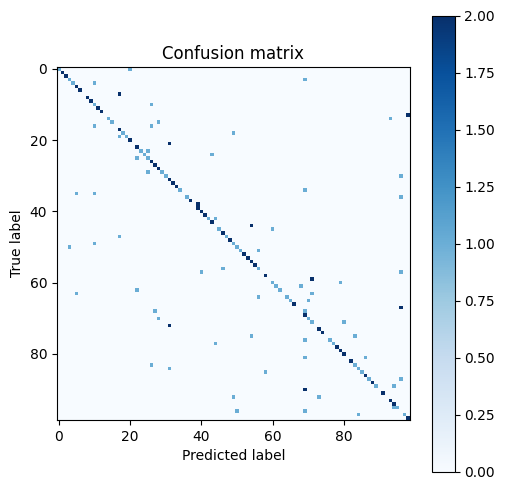

In [26]:
visualize.plot_confusion_matrix(show_label=False)
# visualize.plot_confusion_matrix(show_label=True)

## Testing on the Test dataset

In [57]:
# Predict Test Set
clf = model.model
test = pd.read_csv('../data/raw/test.csv')

# Remove the "id" column from the test data
test_no_id = test.drop(['id'], axis=1)

test_predictions = clf.predict_proba(test_no_id)
classes = list(constants.get_labels())

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test.id)
submission.reset_index()

# Export Submission
submission.to_csv(f'../data/processed/submission_{clf}.csv', index=False)
submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,0.004532,0.069170,0.001425,0.005783,0.030054,0.013123,0.000387,0.001945,0.013729,...,0.002943,0.000559,0.005508,0.005518,0.007936,0.008388,0.013657,0.002029,0.006483,0.018614
590,1577,0.006383,0.016536,0.001407,0.018205,0.009782,0.007294,0.000942,0.009904,0.016963,...,0.003841,0.001075,0.020867,0.010198,0.017348,0.018449,0.012968,0.003956,0.002638,0.025846
591,1579,0.000510,0.003505,0.001305,0.005961,0.003006,0.036707,0.000718,0.000561,0.001609,...,0.000277,0.000517,0.001675,0.002872,0.001329,0.001419,0.000933,0.002988,0.014124,0.005918
592,1580,0.000983,0.001811,0.010078,0.032388,0.000323,0.001742,0.004583,0.008022,0.003141,...,0.001980,0.008471,0.002255,0.045437,0.003213,0.005328,0.003458,0.025775,0.000803,0.015776
593,1583,0.000830,0.001232,0.007517,0.013768,0.000341,0.003238,0.002853,0.000767,0.002361,...,0.000688,0.003983,0.001550,0.009188,0.002437,0.002562,0.001901,0.042641,0.001789,0.007656
